## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## 2. Import data

In [2]:
df = pd.read_csv("Heart Attack.csv")
df.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


This dataset contains eight features and a binary target indicating heart attack presence.

### Feature and target definitions

- age: age of the patient
- gender: biologiccal sex (Female = 0, Male = 1) 
- impluse: heart rate (note: misspelled, correct spelling is “impulse”)
- pressurehight: systolic blood pressure (note: misspelled, correct spelling is “pressurehigh”)
- pressurelow: diastolic blood pressure
- glucose: blood sugar level
- kcm: creatine kinase-MB (CK-MB) level
- troponin: troponin test result 
- class (target): heart attack status (negative = no, positive = yes)

In [3]:
df.describe()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


## 3. Research purpose and questions

#### Research purpose:  

This dataset includes predictors that can be used to estimate the likelihood of a heart attack. In South Korea, my home country, heart attack-related deaths have been on the rise, while the average age of affected individuals has been decreasing. Therefore, identifying key risk factors and predicting heart attack risk may offer valuable insights for early intervention and prevention.
    
#### Research questions:

- Q1. What are the key medical predictors of heart attack?  
- Q2. Which medical features influence these key predictors?  
- Q3. How does age affect the likelihood of having a heart attack?
- Q4. How does age influence the key medical predictors?
- Q5. How does gender affect the likelihood of having a heart attack?  
- Q6. How does gender influence the key medical predictors?
- Q7. Can a predictive model be built to forecast the likelihood of having a heart attack based on the key medical predictors?  
- Q8. Can patients be grouped based on medical features to identify the highest-risk group?

## 4. Preprocess data

### 4.1. Change column names

In [4]:
# Replace "class" into "heart attack"
# Replace "pressurehight" into "pressurehigh"
# Replace "impluse" into "impulse"

df = df.rename(columns = {"impluse":"impulse", "pressurehight":"pressurehigh", "class":"heart attack"}) 
df.head()

,age,gender,impulse,pressurehigh,pressurelow,glucose,kcm,troponin,heart attack
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


### 4.2. Check missing data

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1319 non-null   int64  
 1   gender        1319 non-null   int64  
 2   impulse       1319 non-null   int64  
 3   pressurehigh  1319 non-null   int64  
 4   pressurelow   1319 non-null   int64  
 5   glucose       1319 non-null   float64
 6   kcm           1319 non-null   float64
 7   troponin      1319 non-null   float64
 8   heart attack  1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


The total number of lows is 1319 and there are no missing data.

### 4.3. Replace target classes to numbers (0 and 1)

In [6]:
# Replace "positive" to 1, and "negative" to 0

df['heart attack'] = df['heart attack'].replace({"positive": 1, "negative": 0})

### 4.4. Create age groups

In [7]:
# Create ten age groups

df['age_group'] = pd.cut(df["age"], bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 
                         right = False, 
                         labels = ["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s", "100s"])

In [8]:
df["age_group"].value_counts().sort_index()

age_group
10s       4
20s      49
30s      99
40s     231
50s     316
60s     384
70s     197
80s      32
90s       4
100s      3
Name: count, dtype: int64

Most patients are aged between their 40s and 70s.

### 4.5. Create age group dummies

In [9]:
# Create age group dummy variables to analyze differences across age groups

age_dummies = pd.get_dummies(df["age_group"], prefix = "age")
df = pd.concat([df, age_dummies], axis = 1)
df.head()

,age,gender,impulse,pressurehigh,pressurelow,glucose,kcm,troponin,heart attack,age_group,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s
0,64,1,66,160,83,160.0,1.80,0.012,0,60s,False,False,False,False,False,True,False,False,False,False
1,21,1,94,98,46,296.0,6.75,1.060,1,20s,False,True,False,False,False,False,False,False,False,False
2,55,1,64,160,77,270.0,1.99,0.003,0,50s,False,False,False,False,True,False,False,False,False,False
3,64,1,70,120,55,270.0,13.87,0.122,1,60s,False,False,False,False,False,True,False,False,False,False
4,55,1,64,112,65,300.0,1.08,0.003,0,50s,False,False,False,False,True,False,False,False,False,False


### 4.6. Normalize data

In [10]:
# Normalize the feature scales

scaler = MinMaxScaler()
cols_to_normalize = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

In [11]:
df.head()

,age,gender,impulse,pressurehigh,pressurelow,glucose,kcm,troponin,heart attack,age_group,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s
0,64,1,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068,0,60s,False,False,False,False,False,True,False,False,False,False
1,21,1,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826,1,20s,False,True,False,False,False,False,False,False,False,False
2,55,1,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194,0,50s,False,False,False,False,True,False,False,False,False,False
3,64,1,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749,1,60s,False,False,False,False,False,True,False,False,False,False
4,55,1,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194,0,50s,False,False,False,False,True,False,False,False,False,False


Scales of features were normalized to enhance prediction accuracy.

### 4.7. Assess outliers

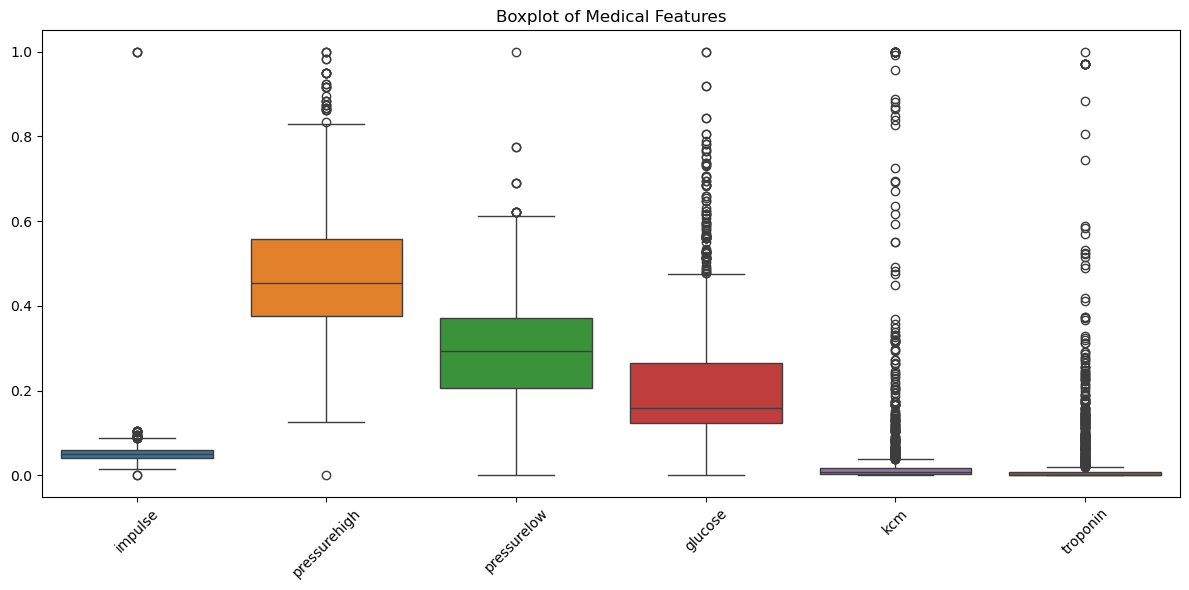

In [12]:
# Draw box plots to assess outliers in medical features

medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[medical_features])
plt.title("Boxplot of Medical Features")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

There are many statistical outliers in the data. These outliers should be retained as they may represent significant predictors for heart attack.

## 5. Assess data normality

To properly assess relationships among all features statistically, data normality must be evaluated to select the appropriate test methods.

### 5.1. Normality (medical features vs heart attack)

In [13]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

results = []

for feature in medical_features:
    
    for heart_attack in df["heart attack"].unique():
        
        data = df[df["heart attack"] == heart_attack][feature].dropna()
        
        # Use shapiro test to assess normality
        
        stat, p = shapiro(data)
        
        results.append({
            "Feature": feature,
            "Heart_Attack": heart_attack,
            "W-statistic": stat,
            "p-value": p,
            "Normal Distribution": "✅ Normal" if p >= 0.05 else "❌ Not Normal"
        })

result_df = pd.DataFrame(results)

print(result_df)

         Feature  Heart_Attack  W-statistic       p-value Normal Distribution
0        impulse             0     0.189128  5.078306e-42        ❌ Not Normal
1        impulse             1     0.182939  0.000000e+00        ❌ Not Normal
2   pressurehigh             0     0.987978  3.366678e-04        ❌ Not Normal
3   pressurehigh             1     0.955008  4.886147e-15        ❌ Not Normal
4    pressurelow             0     0.986149  9.172620e-05        ❌ Not Normal
5    pressurelow             1     0.979907  4.124391e-09        ❌ Not Normal
6        glucose             0     0.783167  1.912701e-25        ❌ Not Normal
7        glucose             1     0.786374  3.054519e-31        ❌ Not Normal
8            kcm             0     0.946627  1.412816e-12        ❌ Not Normal
9            kcm             1     0.410156  2.802597e-45        ❌ Not Normal
10      troponin             0     0.024484  1.121039e-44        ❌ Not Normal
11      troponin             1     0.441669  2.242078e-44       

Based on the Shapiro-Wilk test, none of the features satisfied the normality assumption in either class (p < 0.05). Therefore, instead of ANOVA or independent t-test, Mann-Whawitney U test shoud be applied to assess the associations between the medical features and heart attack.

### 5.2. Normality (medical features vs age groups)

In [14]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

for feature in medical_features:
    
    print(f"Normality test for '{feature}' across age groups")
    
    for age_group in df["age_group"].unique():
        
        data = df[df["age_group"] == age_group][feature].dropna()
        
        # Use shapiro test to assess normality
        
        stat, p = shapiro(data)
        
        result = "✅ Normal (p >= 0.05)" if p >= 0.05 else "❌ Not normal (p < 0.05)"
        
        print(f"  Age group {age_group}: p-value = {p:.4f} → {result}")
    
    print()

Normality test for 'impulse' across age groups
  Age group 60s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 20s: p-value = 0.0299 → ❌ Not normal (p < 0.05)
  Age group 50s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 30s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 40s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 80s: p-value = 0.2025 → ✅ Normal (p >= 0.05)
  Age group 70s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 90s: p-value = 0.1736 → ✅ Normal (p >= 0.05)
  Age group 10s: p-value = 0.3091 → ✅ Normal (p >= 0.05)
  Age group 100s: p-value = 0.2351 → ✅ Normal (p >= 0.05)

Normality test for 'pressurehigh' across age groups
  Age group 60s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 20s: p-value = 0.0616 → ✅ Normal (p >= 0.05)
  Age group 50s: p-value = 0.0000 → ❌ Not normal (p < 0.05)
  Age group 30s: p-value = 0.0438 → ❌ Not normal (p < 0.05)
  Age group 40s: p-value = 0.0003 → ❌ Not normal (p < 0.05)
  Age group 80

Based on the Shapiro-Wilk test results for each medical features across different age groups, most groups significantly violate the normality assumption (p < 0.05). Since the normality assumption is not satisfied in the majority of cases, ANOVA test is not appropriate. Therefore, Kruskal-Wallis test should be applied to assess associations between the medical features and age groups.

### 5.3. Normality (medical features vs gender)

In [15]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

results = []

for feature in medical_features:
    
    for gender in df["gender"].unique():
        
        data = df[df["gender"] == gender][feature].dropna()
        
        # Use shapiro test to assess normality
        
        stat, p = shapiro(data)
        
        results.append({
            "Feature": feature,
            "Gender": gender,
            "W-statistic": stat,
            "p-value": p,
            "Normal Distribution": "✅ Normal" if p > 0.05 else "❌ Not Normal"
        })

result_df = pd.DataFrame(results)

print(result_df)

         Feature  Gender  W-statistic       p-value Normal Distribution
0        impulse       1     0.249125  0.000000e+00        ❌ Not Normal
1        impulse       0     0.152900  1.328403e-40        ❌ Not Normal
2   pressurehigh       1     0.974483  3.312298e-11        ❌ Not Normal
3   pressurehigh       0     0.964275  5.445607e-09        ❌ Not Normal
4    pressurelow       1     0.984049  3.889366e-08        ❌ Not Normal
5    pressurelow       0     0.980115  7.989898e-06        ❌ Not Normal
6        glucose       1     0.779548  1.236204e-32        ❌ Not Normal
7        glucose       0     0.794953  2.160953e-23        ❌ Not Normal
8            kcm       1     0.315615  0.000000e+00        ❌ Not Normal
9            kcm       0     0.312640  9.344661e-38        ❌ Not Normal
10      troponin       1     0.369347  0.000000e+00        ❌ Not Normal
11      troponin       0     0.255563  7.877097e-39        ❌ Not Normal


Based on the Shapiro-Wilk test, none of the features satisfied the normality assumption in either gender group (p < 0.05). Therefore, instead of ANOVA or independent t-test, Mann-Whitney U test should be applied to assess the associations between the medical features and gender.

## 6. Answer research questions

### Q1. What are the key medical predictors of heart attack?  

### Q1.1. Relationships between medical features and heart attack (Mann-Whitney U test)

In [16]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]
target = "heart attack"

for feature in medical_features:
    print(f"{feature} vs {target}")
    
    heart_attack_class = df[df[target] == 1][feature].dropna()
    non_heart_attack_class = df[df[target] == 0][feature].dropna()
    
    # Mann-Whitney U test
    
    stat, p_value = mannwhitneyu(heart_attack_class, non_heart_attack_class, alternative = "two-sided")
    print(f"  U-statistic: {stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        
        print("  ✅ Statistically significant difference in the feature between heart attack and non heart attack classes.")
        print("--------------------------------------------------")
        
    else:
        
        print("  ❌ No statistically significant difference in the feature between heart attack and non heart attack classes.")
        print("--------------------------------------------------")


impulse vs heart attack
  U-statistic: 206435.5000
  p-value: 0.9656
  ❌ No statistically significant difference in the feature between heart attack and non heart attack classes.
--------------------------------------------------
pressurehigh vs heart attack
  U-statistic: 197212.5000
  p-value: 0.1847
  ❌ No statistically significant difference in the feature between heart attack and non heart attack classes.
--------------------------------------------------
pressurelow vs heart attack
  U-statistic: 204218.5000
  p-value: 0.7748
  ❌ No statistically significant difference in the feature between heart attack and non heart attack classes.
--------------------------------------------------
glucose vs heart attack
  U-statistic: 201761.5000
  p-value: 0.5151
  ❌ No statistically significant difference in the feature between heart attack and non heart attack classes.
--------------------------------------------------
kcm vs heart attack
  U-statistic: 280469.5000
  p-value: 0.0000
  ✅ St

According to the Mann-Whitney U tests, both kcm and troponin have statistically significant associations with the heart attack occurrence (p-value < 0.05). On the other hand, the other features do not have statistically significant associations with the heart attack occurrence (p-value >= 0.05). Accordingly, the key medical predictors of heart attack are kcm and troponin.

### Q2.  Which medical features influence these key predictors?

### Q2.1. Correlations between medical features (Heatmap)

In [17]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

cor_matrix_medical = df[medical_features].corr()

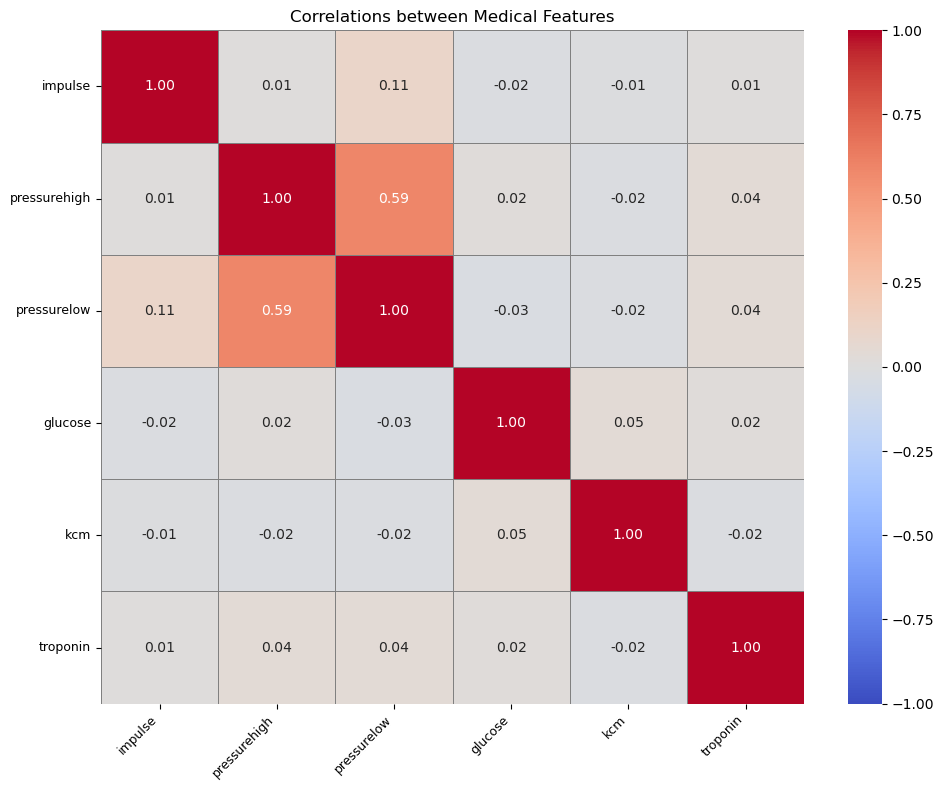

In [18]:
plt.figure(figsize = (10, 8))

sns.heatmap(
    cor_matrix_medical,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    vmin = -1, vmax = 1,
    linewidths = 0.5,
    linecolor = "gray"
)

plt.title("Correlations between Medical Features")
plt.xticks(rotation = 45, ha = "right", fontsize = 9)
plt.yticks(rotation = 0, fontsize = 9)
plt.tight_layout()
plt.show()

A heatmap was used to visualize the pairwise correlations among six medical features. The analysis reveals that most medical features show weak correlations with each other, except for a moderate positive correlation of 0.59 between pressurelow and pressurehigh. This suggests that the features are largely independent. Based on the correlation analysis, none of the medical features exhibit a strong influence on the key predictors, kcm and troponin.

### Q2.2. Correlations between medical features (Pair Plot)

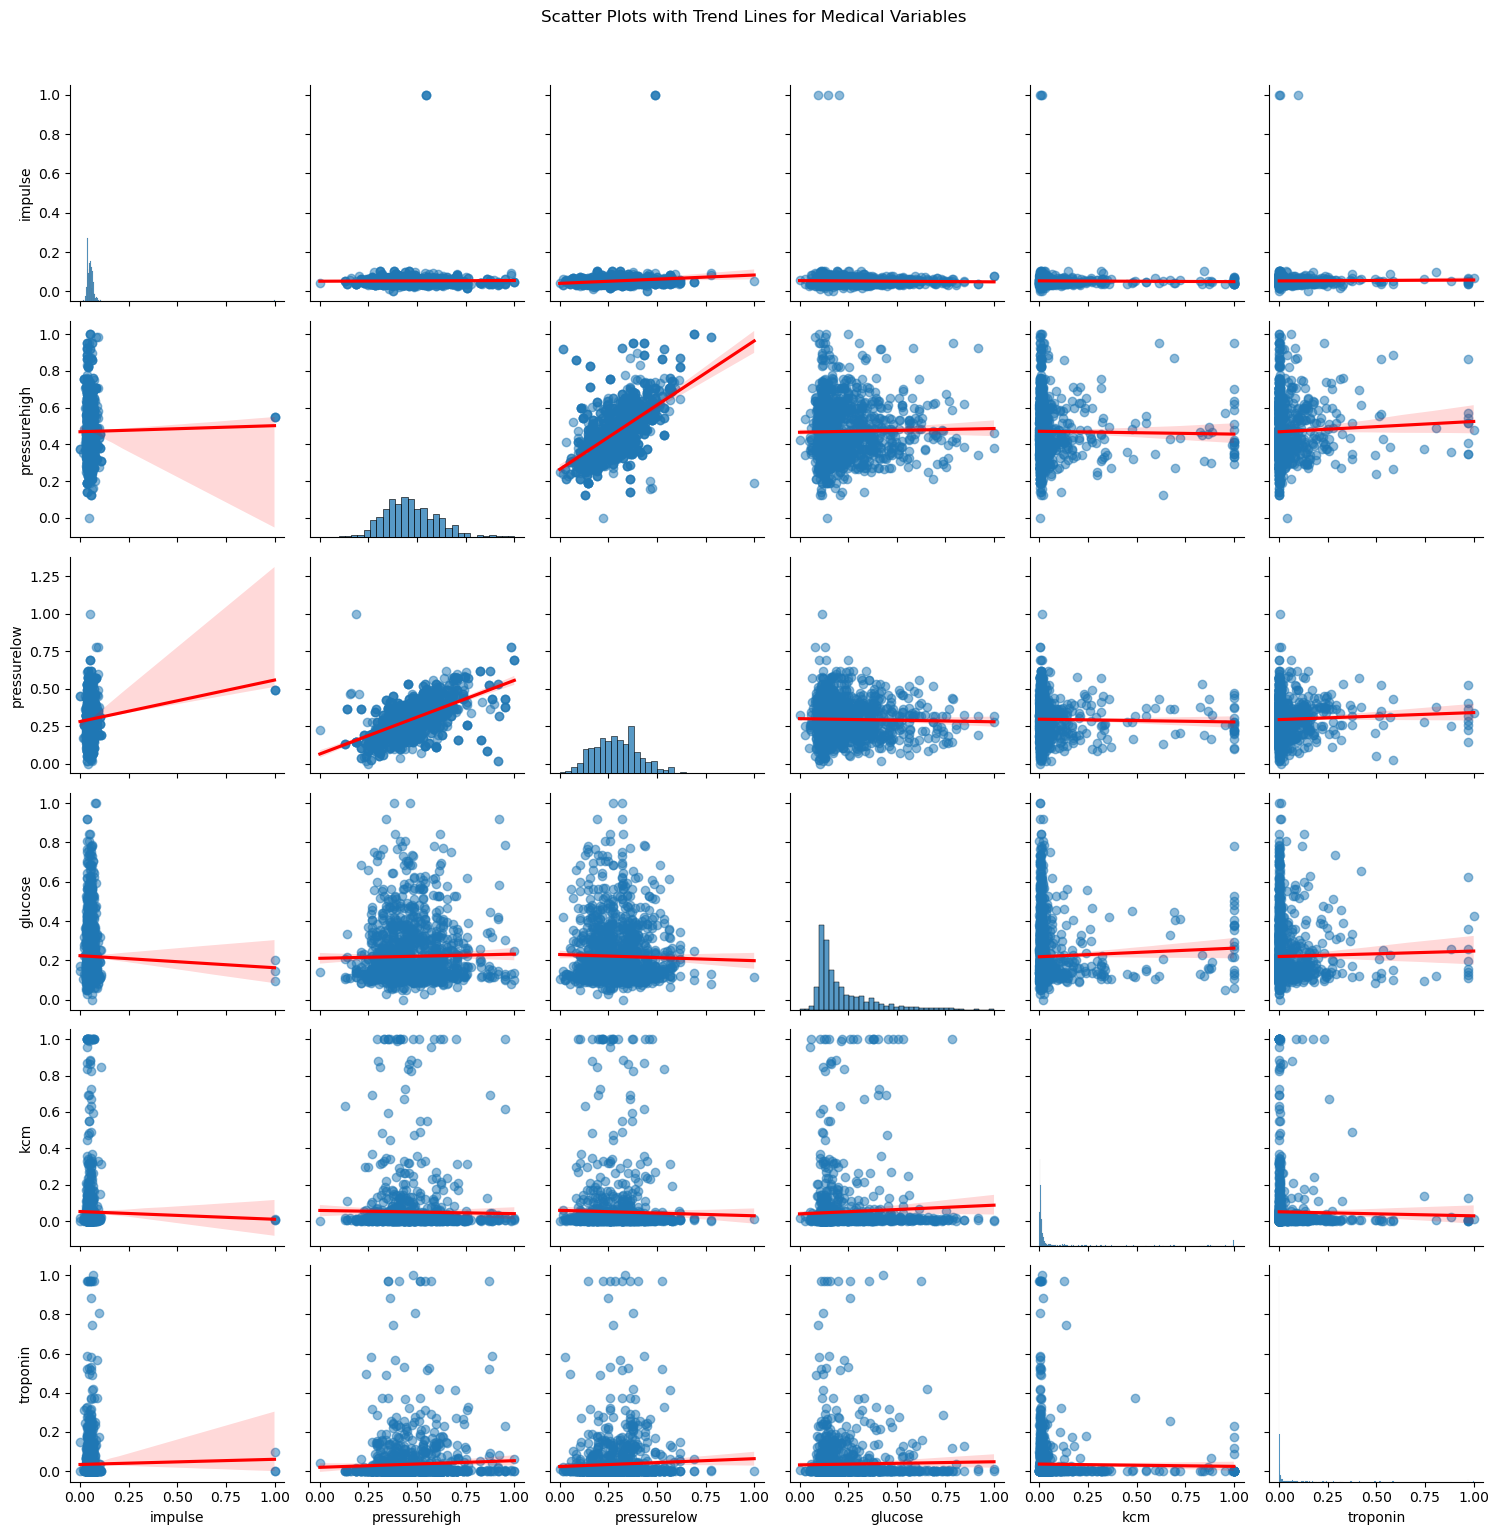

In [19]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

# Draw scatter plots and trend lines

sns.pairplot(df[medical_features], kind = "reg", plot_kws = {"line_kws":{"color":"red"}, "scatter_kws": {"alpha": 0.5}})

plt.suptitle("Scatter Plots with Trend Lines for Medical Variables", y = 1.02)
plt.tight_layout()
plt.show()

This pairplot reveals that most medical features have weak statistical associations with the key predictors, while "pressurelow" and "pressurehigh" show a significant positive linear relationship.

### Q3. How does age affect the likelihood of having a heart attack?

### Q3.1. Number of patients by age groups

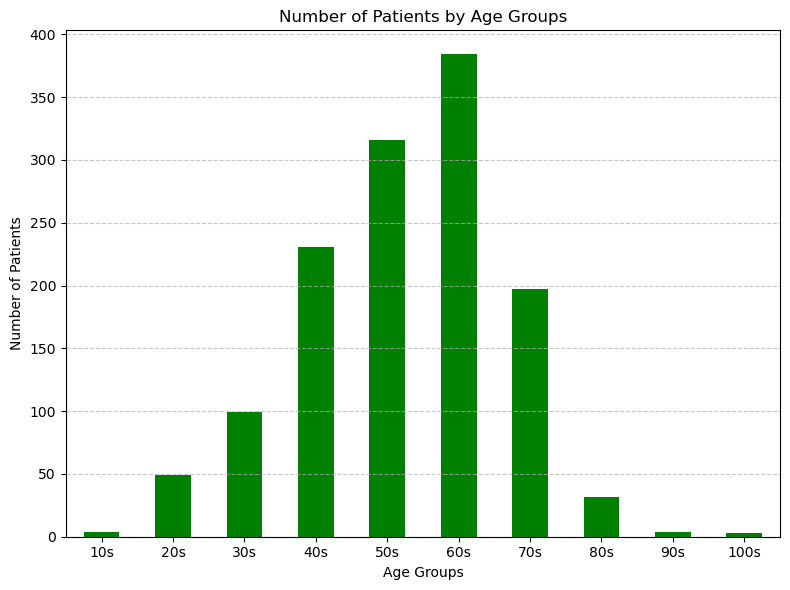

In [20]:
age_counts = df["age_group"].value_counts().sort_index()

plt.figure(figsize = (8, 6))
age_counts.plot(kind = "bar", color = "green")

plt.title("Number of Patients by Age Groups")
plt.ylabel("Number of Patients")
plt.xlabel("Age Groups")
plt.xticks(rotation = 360)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

The age distribution roughly follows a normal distribution, with most patients falling within the 40 to 70 age groups.

### Q3.2. Heart attack rate by age groups

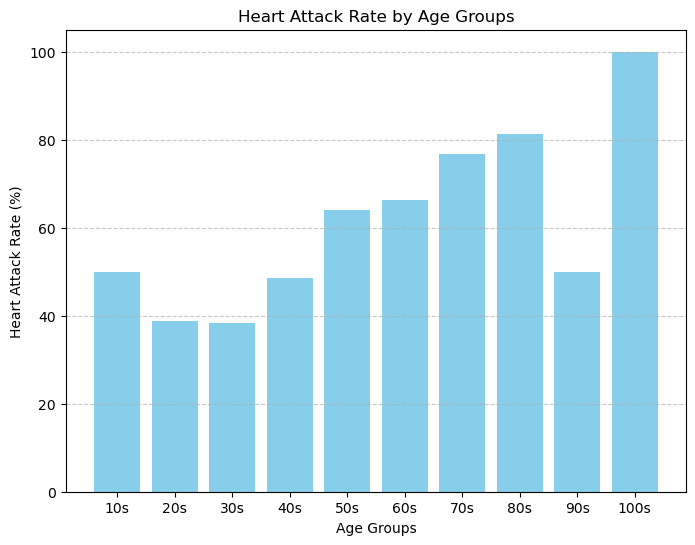

In [21]:
age_group_stats = df.groupby("age_group")["heart attack"].value_counts(normalize = True).unstack().fillna(0)
age_group_stats["heart_attack_percent"] = age_group_stats[1] * 100  

plt.figure(figsize = (8, 6))
plt.bar(age_group_stats.index, age_group_stats["heart_attack_percent"], color = 'skyblue')

plt.title("Heart Attack Rate by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Heart Attack Rate (%)")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

The heart attack rate tends to increase with age. In the 100s age group, it reaches 100%, possibly due to the small sample size. While the rate is relatively low in younger age groups, it drastically increases from the 50s onward, indicating higher vulnerability among older populations. Chi-Square test was conducted to determine whether these differences are statistically significant.

### Q3.3. Relationship between age groups and heart attack (Chi-Square test)

In [22]:
contingency_table = pd.crosstab(df["age_group"], df["heart attack"], margins = True)

# Chi-Square Test

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table.iloc[:-1, :-1])

print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Assess expected frequnencies (expected frequnencies >= 5)

if (expected < 5).sum() > 0:
    
    print("\n⚠️ Some expected frequencies are less than 5. Chi-square test assumptions may be violated.")
    
else:
    
    print("\n✅ All expected frequencies are greater than or equal to 5. Chi-square test assumptions are satisfied.")

# Assess p-value

if p_value < 0.05:
    
    print("✅ There is a statistically significant relationship")
    
else:
    
    print("❌ There is no statistically significant relationship")

Chi-squared statistic: 80.8613
P-value: 0.0000

⚠️ Some expected frequencies are less than 5. Chi-square test assumptions may be violated.
✅ There is a statistically significant relationship


Some expected frequencies are less than 5, which violates the assumptions of the Chi-square test. Since Fisher's Exact test cannot be applied due to the multiple age groups (more than two), the result should be interpreted with caution. Nevertheless, the analysis
suggests a potential association between age groups (age) and heart attack occurrence. In conclusion, the likelihood of having a heart attack tends to increase with age.

### Q4. How does age influence the key medical predictors?

### Q4.1. The average levels of key medical predictors by age groups

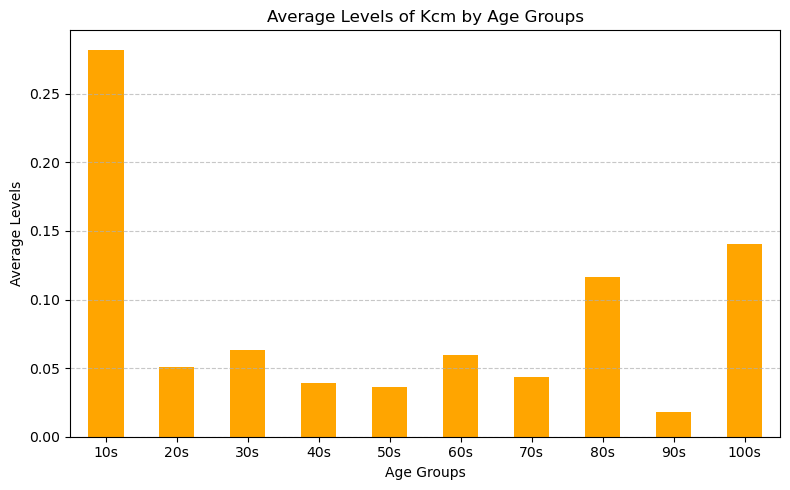

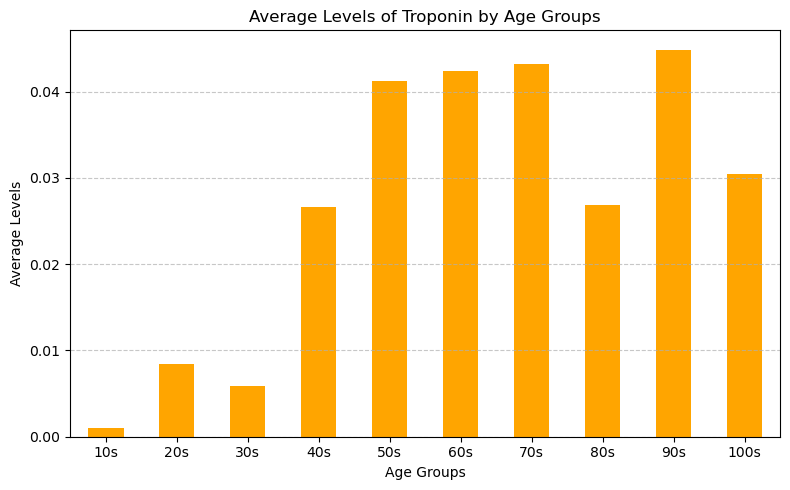

In [23]:
medical_features = ["kcm", "troponin"]

for feature in medical_features:
    
    age_grouped = df.groupby("age_group")[feature].mean()
    
    plt.figure(figsize = (8, 5))
    
    age_grouped.plot(kind = "bar", color = "orange")
    
    plt.title(f"Average Levels of {feature.title()} by Age Groups")
    plt.ylabel("Average Levels")
    plt.xlabel("Age Groups")
    plt.xticks(rotation = 360)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
    plt.tight_layout()
    plt.show()

Key medical predictors of heart attack, identified in Q1, are kcm and troponin.

For kcm, the highest average level is observed in the 10s age group. Between the 20s and 70s, average levels remain relatively low and stable, followed by a noticeable increase in the 80s and beyond.

In the case of troponin, average levels gradually increase from the 10s, peaking between the 60s and 90s. Levels remain consistently high from the 50s through 90s, with the highest level in the 90s. The lowest level is observed in the 10s. 

Kruskal-Wallis tests were conducted to assess whether these differences are statistically significant.

### Q4.2. The average levels of key medical predictors by age group (Kruskal-Wallis test)

In [24]:
medical_features = ["kcm", "troponin"]

for feature in medical_features:
    
    groups = [df[df["age_group"] == age_group][feature].dropna() for age_group in df["age_group"].unique()]
    
    # Kruskal-Wallis test
    
    stat, p_value = kruskal(*groups)
    
    print(f"Kruskal-Wallis Test for '{feature}' across age groups")
    print("--------------------------------------------------")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        
        print("✅ The differences are statistically significant (p < 0.05)\n")
        
    else:
        
        print("❌ The differences are not statistically significant (p ≥ 0.05)\n")


Kruskal-Wallis Test for 'kcm' across age groups
--------------------------------------------------
p-value: 0.0347
✅ The differences are statistically significant (p < 0.05)

Kruskal-Wallis Test for 'troponin' across age groups
--------------------------------------------------
p-value: 0.0000
✅ The differences are statistically significant (p < 0.05)



The average levels of key medical predictors (kcm and troponin) were compared across age groups. According to the Kruskal-Wallis tests, the distributions of both kcm and troponin levels differed significantly among age groups (p < 0.05). These results indicate a potential association between age and the levels of these key medical predictors.

### Q4.3. Correlations between age groups and medical features

In [25]:
medical_features = ["impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]

# Remove age_group column 

df_numeric = df.drop(columns = ["age_group"])

# Calculate correlations 

cor_matrix_age = df_numeric[age_dummies.columns.tolist() + medical_features].corr()

# Calculate correlation between age_groups and medical features

age_corr = cor_matrix_age.loc[age_dummies.columns, medical_features]

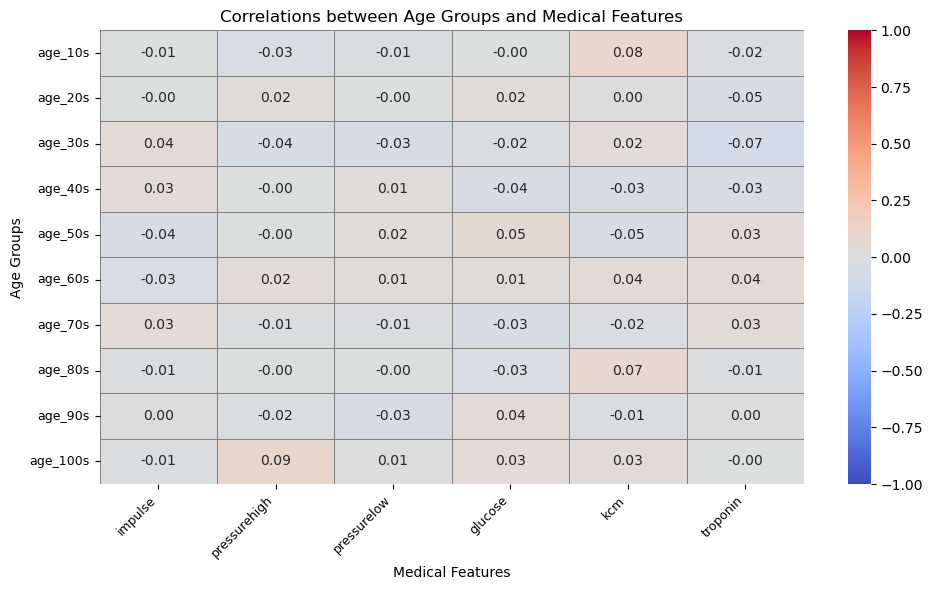

In [26]:
plt.figure(figsize = (10, 6))

sns.heatmap(
    age_corr, 
    annot = True,              
    fmt = ".2f",               
    cmap = "coolwarm",         
    vmin = -1, vmax = 1,         
    linewidths = 0.5,          
    linecolor = 'gray'         
)

plt.title("Correlations between Age Groups and Medical Features")
plt.ylabel("Age Groups", fontsize = 10)
plt.xlabel("Medical Features", fontsize = 10)

plt.xticks(rotation = 45, ha = 'right', fontsize = 9)
plt.yticks(rotation = 0, fontsize = 9)

plt.tight_layout()
plt.show()

According to the heatmap, there are no strong or statistically significant correlations between the different age groups and the six medical features, including the key predictors, kcm and troponin.

### Q5. How does gender affect the likelihood of having a heart attack?

### Q5.1. Number of patients by gender

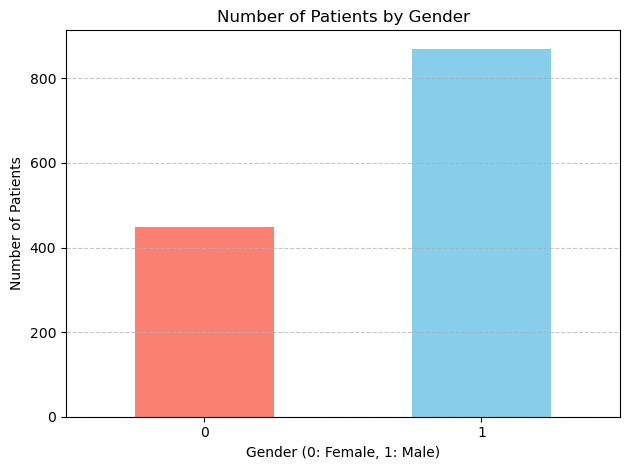

In [27]:
gender_counts = df["gender"].value_counts().sort_index()

gender_counts.plot(kind = "bar", color = ["salmon", "skyblue"])

plt.title("Number of Patients by Gender")
plt.ylabel("Number of Patients")
plt.xlabel("Gender (0: Female, 1: Male)")
plt.xticks(rotation = 360)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

The number of male patients is almost double that of female patients.

### Q5.2. Heart attack rate by gender

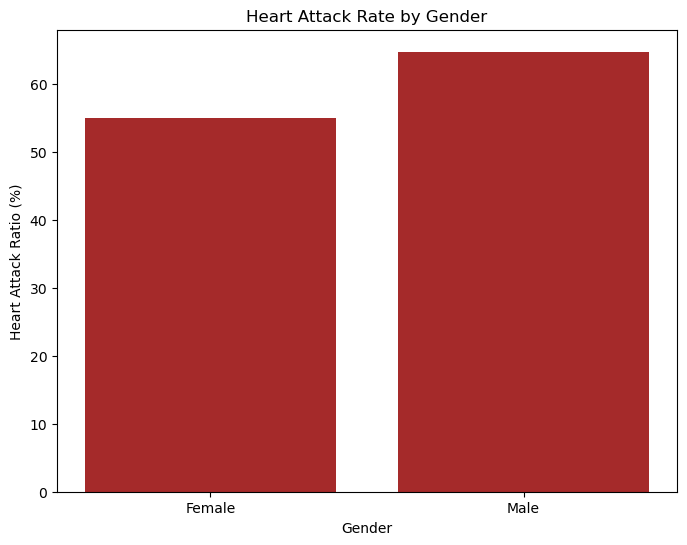

In [28]:
gender_stats = df.groupby("gender")["heart attack"].value_counts(normalize = True).unstack().fillna(0)
gender_stats["heart_attack_percent"] = gender_stats[1] * 100  

gender_stats.index = gender_stats.index.map({0: 'Female', 1: 'Male'})

plt.figure(figsize = (8, 6))
plt.bar(gender_stats.index, gender_stats["heart_attack_percent"], color = 'brown')

plt.title("Heart Attack Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Heart Attack Ratio (%)")
plt.show()

Male patients exhibit a higher heart attack rate than female patients. Chi-Square test was conducted to assess whether the differences are statistically significant.

### Q5.3. Relationship between gender and heart attack (Chi-Square test)

In [29]:
contingency_table = pd.crosstab(df["gender"], df["heart attack"], margins = True)

# Chi-Square Test

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table.iloc[:-1, :-1])

print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Assess expected frequnencies (expected frequnencies >= 5)

if (expected < 5).sum() > 0:
    
    print("\n⚠️ Some expected frequencies are less than 5. Chi-square test assumptions may be violated.")
    
else:
    
    print("\n✅ All expected frequencies are greater than or equal to 5. Chi-square test assumptions are satisfied.")

# Assess p-value
    
if p_value < 0.05:
    
    print("✅ There is a statistically significant relationship")
    
else:
    
    print("❌ There is no statistically significant relationship")

Chi-squared statistic: 11.3563
p-value: 0.0008

✅ All expected frequencies are greater than or equal to 5. Chi-square test assumptions are satisfied.
✅ There is a statistically significant relationship


The Chi-Square test shows a statistically significant association between gender and heart attack occurrence (p-value < 0.05), indicating that gender affects the likeihood of having a heart attack.

### Q6. How does gender influence the key medical predictors?

### Q6.1. The average levels of key medical features by gender

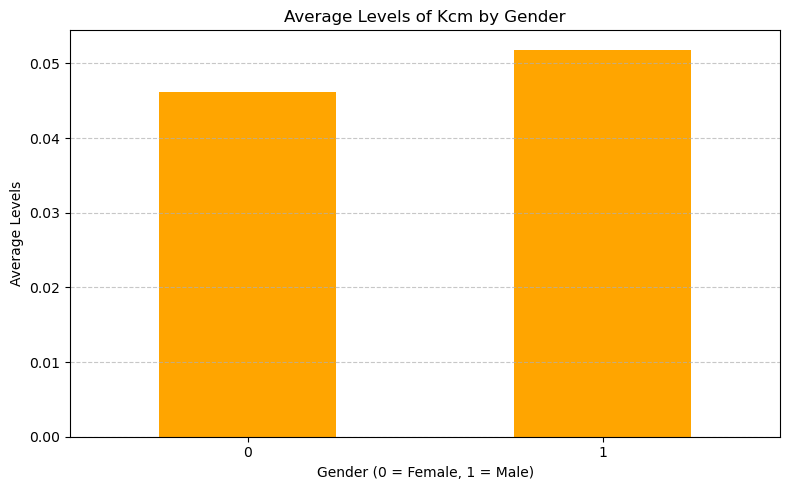

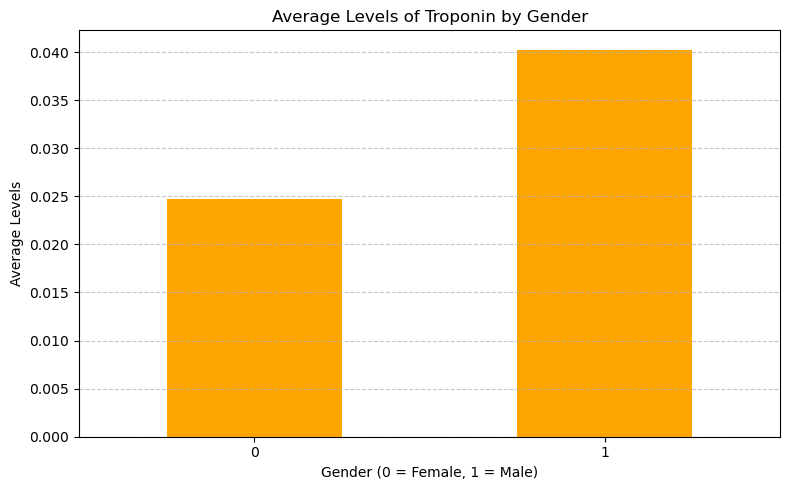

In [30]:
medical_features = ["kcm", "troponin"]

for feature in medical_features:
    
    gender_grouped = df.groupby("gender")[feature].mean()
    
    plt.figure(figsize = (8, 5))
    
    gender_grouped.plot(kind = "bar", color = "orange")
    
    plt.title(f"Average Levels of {feature.title()} by Gender")
    plt.ylabel("Average Levels")
    plt.xlabel("Gender (0 = Female, 1 = Male)")
    plt.xticks(rotation = 360)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
    plt.tight_layout()
    plt.show()

Key medical predictors of heart attack, identified in Q1, are kcm and troponin.

For both kcm and troponin, males exhibit higher average levels than females. 

Mann-Whitney U tests were conducted to determine whether the differences are statistically significant.

### Q6.2. The average levels of key medical features by gender (Mann-Whitney U test)

In [31]:
medical_features = ["kcm", "troponin"]

for feature in medical_features:
    
    male_group = df[df["gender"] == 1][feature].dropna()
    female_group = df[df["gender"] == 0][feature].dropna()
    
    # Mann-Whitney U test
    
    stat, p_value = mannwhitneyu(male_group, female_group, alternative = "two-sided")
    
    print(f"Mann-Whitney U Test for '{feature}' across gender")
    print("--------------------------------------------------")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        
        print("✅ The differences are statistically significant (p < 0.05)\n")
        
    else:
        
        print("❌ The differences are not statistically significant (p ≥ 0.05)\n")


Mann-Whitney U Test for 'kcm' across gender
--------------------------------------------------
p-value: 0.3169
❌ The differences are not statistically significant (p ≥ 0.05)

Mann-Whitney U Test for 'troponin' across gender
--------------------------------------------------
p-value: 0.0000
✅ The differences are statistically significant (p < 0.05)



The average levels of key medical predictors were compared across gender. According to the Mann-Whitney U tests, only troponin levels showed statistically significant differences between males and females (p < 0.05), indicating a potential association between gender and troponin. In contrast, the differences in kcm levels were not statistically significant (p ≥ 0.05).

### Q7. Can a predictive model be built to forecast the likelihood of having a heart attack based on the key medical predictors? 

### Q7.1. Check the number of target classes

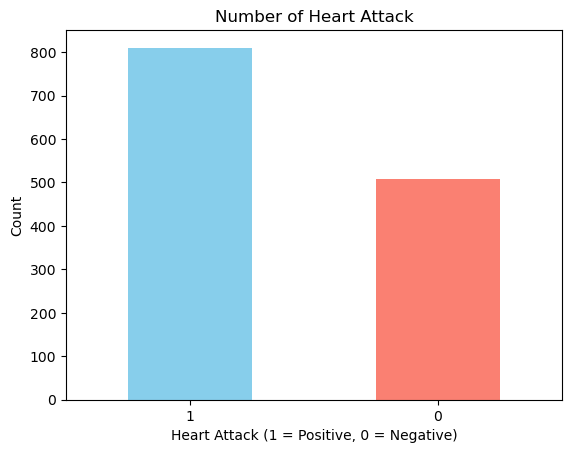

In [32]:
heart_attack_counts = df["heart attack"].value_counts()

heart_attack_counts.plot(kind = "bar", color = ["skyblue", "salmon"])

plt.xlabel("Heart Attack (1 = Positive, 0 = Negative)")
plt.ylabel("Count")
plt.title("Number of Heart Attack")
plt.xticks(rotation = 360)

plt.show()

The target classes are imbalanced, with significantly more positive (1) cases than negative (0) cases. Therefore, data augmentation should be considered to address this imbalance and enhance model training effectiveness.

### Q7.2.1. Develop Logistic Regression model 

#### Advantages:
1. Logistic regression is a linear model, making it easy to interpret how each feature's coefficient influences the outcome.
2. Regularization (L1 or L2) can be easily applied to prevent overfitting and enhance generalization.
3. It is particularly well-suited for binary classification tasks, where the target variable has two possible outcomes.

#### Disadvantages:
1. Logistic regression may struggle with high-dimensional data (many features) and can suffer from poor performance and overfitting if feature selection isn't properly done.
2. It is sensitive to the scale of the input features, making normalization or standardization necessary.
3. Its performance may be inferior to that of complex models such as random forest or gradient boosting.
4. It is sensitive to outliers.
5. It has limitations in handling non-linear relationships between features and the target variable.

#### Reasons for Selection:
A logistic regression model is well-suited for binary classification tasks, especially when the number of features is small, making it appropriate for this research purpose. Although it is sensitive to outliers, it provides a strong baseline for evaluating model performance and serves as a benchmark for comparison with more complex models in subsequent analyses.

In [33]:
# Prepare training and test data 

X = df[["age", "gender", "kcm", "troponin"]]
y = df["heart attack"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Apply SMOTE to address class imbalance

smote = SMOTE(random_state = 42, sampling_strategy = "auto")
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Make a logistic regression model

lr_model = LogisticRegression(random_state = 42, max_iter = 1000)

# Set parameters for GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],     # Regularization strength
    "penalty": ["l2"],                # L2 regularization (default)
    "solver": ["lbfgs"]               # Solver compatible with L2 penalty
}

# Make a GridSearchCV

grid_search = GridSearchCV(estimator = lr_model, param_grid = param_grid,
                           cv = 3, n_jobs = 1, verbose = 0, scoring = "f1")

# Train the model

grid_search.fit(X_smote, y_smote)

# Check the best parameter

print("Best parameters found: ", grid_search.best_params_)

# Perform prediction with the best model

best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

# Check class imbalance (original y and y after smote)

print("Original class distribution (y):")
print(y.value_counts())
print("\nResampled class distribution (y_smote):")
print(y_smote.value_counts())

# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters found:  {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Original class distribution (y):
heart attack
1    810
0    509
Name: count, dtype: int64

Resampled class distribution (y_smote):
heart attack
0    647
1    647
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       101
           1       0.91      0.77      0.83       163

    accuracy                           0.81       264
   macro avg       0.81      0.82      0.81       264
weighted avg       0.83      0.81      0.81       264



The best parameters were found to be {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}. To address class the imbalance, SMOTE was applied to balance the sample sizes across classes. Four key features -- age, gender, kcm, and troponin -- were selected to predict the occurrence of heart attack.

### Prediction outcome

#### Class 0:  
- Precision (70%): when the model predicts 100 instances as class 0 (negative), 70 of them are correct.  
- Recall (88%): when there are 100 actual class 0 (negative), the model correctly identifies 88 of them.  
- F1 Score (78%): F1 Score gives a balanced evaluation of the model's performance by combining both precision and recall.

#### Class 1:  
- Precision (91%): when the model predicts 100 instances as class 1 (positive), 91 of them are correct.  
- Recall (77%): when there are 100 actual class 1 (positive), the model correctly identifies 77 of them.  
- F1 Score (83%): F1 Score gives a balanced evaluation of the model's performance by combining both precision and recall.

#### Accuracy:  
- The overall accuracy is 81%.  

#### Macro Average:  
- This calculates the average of precision (81%), recall (82%), and F1-score (81%) across all classes. All classes are treated equally.   

#### Weighted Average:  
- This calculates the average of precision (83%), recall (81%), and F1-score (81%) across all classes. Classes are weighted by the number of true instances for each class.

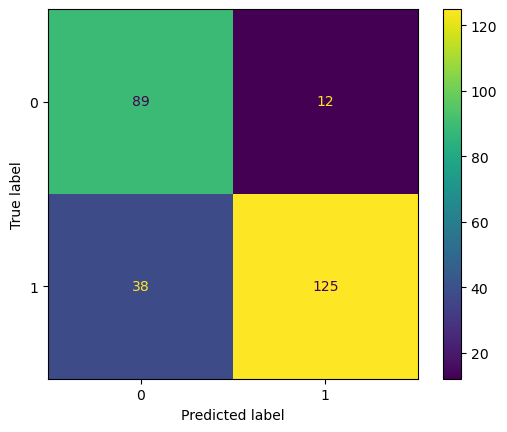

In [34]:
# Check predictiom outcomes

ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test, y_test)

#### Non heart attack (True label = 0):

- Number of correct prediction: 89
- Number of wrong prediction: 12 
    
#### Heart attack (True label = 1):

- Number of correct prediction: 125
- Number of wrong prediction: 38 

### Q7.2.2. Logistic Regression - assess overfitting

In [35]:
# model accuracy with train data

train_accuracy = accuracy_score(y_smote, best_lr_model.predict(X_smote))
train_f1 = f1_score(y_smote, best_lr_model.predict(X_smote))

# model accuracy with test data

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Training Accuracy: 0.8338
Training F1-Score: 0.8122
Test Accuracy: 0.8106
Test F1-Score: 0.8333


To assess potential overfitting, the logistic regression model's accuracy and F1-score were evaluated on both the training and test datasets. Since the differences in both metrics are minimal, the model does not exhibit signs of overfitting.

### Q7.3.1. Develop Decision Tree model 

#### Advantages:
1. It is easy to understand how each feature affects the outcome, as each node in the tree works like a filter.
2. Decision tree can effectively handle non-linear relationships between features and the target variable.
3. It is less sensitive to feature scaling.
4. It can handle both continuous and categorical data, making them versatile for different types of problems.
5. Overfitting can be mitigated by pruning the tree or by limiting the maximum depth of the tree.
6. It is less sensitive to outliers

#### Disadvantages:
1. Decision tree is prone to overfitting, especially when the tree is deep.
2. Training on large datasets can be computationally expensive.
3. It may struggle with modeling complex feature interactions and continuous target distributions.  

#### Reasons for Selection:
A decision tree model is less sensitive to outliers compared to a logistic regression model, suggesting it may perform better on this dataset, which contains many outliers. Moreover, a decision tree model offers greater flexibility to improve model performance by controlling parameters such as depth, split criteria, and leaf size. Additionally, the model provides insights into feature importance, enhancing model interpretability.

In [36]:
# Prepare training and test data 

X = df[["age", "gender", "kcm", "troponin"]]
y = df["heart attack"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Apply SMOTE to address class imbalance

smote = SMOTE(random_state = 42, sampling_strategy = "auto")
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Make a decision tree model

dt_model = DecisionTreeClassifier(random_state = 42)

# Set parameters for GridSearchCV

param_grid = {
    "max_depth": [3, 5, 10, 15, 20],              
    "min_samples_split": [2, 5, 10, 15, 20],            
    "min_samples_leaf": [1, 2, 4, 8, 16],               
    "criterion": ["gini", "entropy"]            
}

# Make a GridSearchCV

grid_search = GridSearchCV(estimator = dt_model, param_grid = param_grid, 
                           cv = 3, n_jobs = 1, verbose = 0, scoring = "f1")

# Train the model

grid_search.fit(X_smote, y_smote)

# Check the best parameter

print("Best parameters found: ", grid_search.best_params_)

# Perform prediction with the best model

best_dt_model = grid_search.best_estimator_
y_pred = best_dt_model.predict(X_test)

# Check class imbalance (original y and y after smote)

print("Original class distribution (y):")
print(y.value_counts())
print("\nResampled class distribution (y_smote):")
print(y_smote.value_counts())

# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters found:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Original class distribution (y):
heart attack
1    810
0    509
Name: count, dtype: int64

Resampled class distribution (y_smote):
heart attack
0    647
1    647
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       101
           1       0.98      0.99      0.98       163

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264



The best parameters were found to be {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}. To address class imbalance, SMOTE was applied to balance the sample sizes across classes. Four key features -- age, gender, kcm, and troponin -- were selected to predict the occurrence of heart attack.

#### Class 0:  
- Precision (98%): when the model predicts 100 instances as class 0 (negative), 98 of them are correct.  
- Recall (97%): when there are 100 actual class 0 (negative), the model correctly identifies 97 of them.  
- F1 Score (98%): F1 Score gives a balanced evaluation of the model's performance by combining both precision and recall.

#### Class 1:  
- Precision (98%): when the model predicts 100 instances as class 1 (positive), 98 of them are correct.  
- Recall (99%): when there are 100 actual class 1 (positive), the model correctly identifies 99 of them.  
- F1 Score (98%): F1 Score gives a balanced evaluation of the model's performance by combining both precision and recall.

#### Accuracy:  
- The overall accuracy is 98%.  

#### Macro Average:  
- This calculates the average of precision (98%), recall (98%), and F1-score (98%) across all classes. All classes are treated equally.   

#### Weighted Average:  
- This calculates the average of precision (98%), recall (98%), and F1-score (98%) across all classes. Classes are weighted by the number of true instances for each class.

### Feature importance

In [37]:
# Check feature importance of the best decision tree model

feature_importance = best_dt_model.feature_importances_

# Create a DataFrame to display the feature importance

importance_df = pd.DataFrame({
    
    "Feature": X.columns,
    "Importance": feature_importance
    
})

# Sort the features by importance

importance_df = importance_df.sort_values(by = "Importance", ascending = False)

# Display the sorted feature importance

print("\nFeature Importance:")
print(importance_df)


Feature Importance:
    Feature  Importance
3  troponin    0.671565
2       kcm    0.313798
1    gender    0.014638
0       age    0.000000


According to the feature importance results, troponin (67.2%) and kcm(31.4%) are the two most influential predictors of heart attack, while age and gender contribute minimally.

### Prediction outcomes

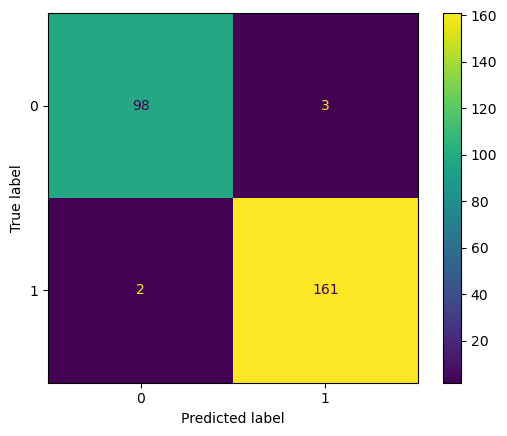

In [38]:
# Check predictiom outcomes

ConfusionMatrixDisplay.from_estimator(best_dt_model, X_test, y_test)

#### Non heart attack (True label = 0):

- Number of correct prediction: 98
- Number of wrong prediction: 3 
    
#### Heart attack  (True label = 1):

- Number of correct prediction: 161
- Number of wrong prediction: 2 

### Q7.3.2. Decision Tree - assess overfitting

In [39]:
# model accuracy with train data

train_accuracy = accuracy_score(y_smote, best_dt_model.predict(X_smote))
train_f1 = f1_score(y_smote, best_dt_model.predict(X_smote))

# model accuracy with test data

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Training Accuracy: 0.9954
Training F1-Score: 0.9954
Test Accuracy: 0.9811
Test F1-Score: 0.9847


To assess potential overfitting, the decision tree model's accuracy and F1-score were evaluated on  both the training and test datasets. Since the differences in both metrics are minimal, the model does not exhibit signs of overfitting.

### Q7.4.1. Develop Random Forest model

#### Advantages:
1. Random forest prevents overfitting commonly seen in single decision tree models by combining multiple trees into an ensemble.
2. It typically offers high performance in terms of both accuracy and robustness across various types of problems.
3. It can handle both continuous and categorical data, making it a versatile model.
4. It provides a useful feature importance ranking, aiding in feature selection and providing insights into the model's decision-making process.
5. It is less sensitive to missing data and outliers.

#### Disadvantages:
1. Since random forest is an ensemble of many decision trees, it is hard to interpret.
2. Training a random forest model requires significant computational resources, resulting in high computational cost.
3. Due to the multiple trees involved in the prediction process, prediction speed can be slower compared to simpler models.
4. While it can handle complex data, it may struggle to model very high-dimensional interactions. 

#### Reasons for Selection:
A random forest model may perform better than a single decision tree model and a logistic regression model because it is an ensemble method that combines multiple decision trees. Although the decision tree model showed overall high performanc, a random forest model may further improve prediction accuracy.

In [40]:
# Prepare training and test data 

X = df[["age", "gender", "kcm", "troponin"]]
y = df["heart attack"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Apply SMOTE to address class imbalance

smote = SMOTE(random_state = 42, sampling_strategy = 1)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Make a random forest model

rf_model = RandomForestClassifier(random_state = 42)

# Set parameters for GridSearchCV

param_grid = {
    "n_estimators": [10, 20, 30],                
    "max_depth": [5, 10, 20],                   
    "min_samples_split": [2, 3, 4],                        
    "min_samples_leaf": [2, 3, 4],                          
    "max_features": ["sqrt", "log2"],                                         
    "criterion": ["gini", "entropy"]                       
}

# Make a GridSearchCV

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                           cv = 3, n_jobs = 1, verbose = 0, scoring = "f1")

# Train the model

grid_search.fit(X_smote, y_smote)

# Check the best parameter

print("Best parameters found: ", grid_search.best_params_)

# Perform prediction with the best model

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Check class imbalance (original y and y after smote)

print("Original class distribution (y):")
print(y.value_counts())
print("\nResampled class distribution (y_smote):")
print(y_smote.value_counts())

# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Original class distribution (y):
heart attack
1    810
0    509
Name: count, dtype: int64

Resampled class distribution (y_smote):
heart attack
0    647
1    647
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       101
           1       0.98      0.98      0.98       163

    accuracy                           0.97       264
   macro avg       0.97      0.97      0.97       264
weighted avg       0.97      0.97      0.97       264



The best parameters were found to be {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}. To address class imbalance, SMOTE was applied to balance the sample sizes across classes. Four features -- age, gender, kcm, and troponin -- were selected to predict the occurrence of heart attack.

#### Class 0:  
- Precision (97%): when the model predicts 100 instances as class 0 (negative), 97 of them are correct.  
- Recall (96%): when there are 100 actual class 0 (negative), the model correctly identifies 96 of them.  
- F1 Score (97%): F1 Score gives a balanced evaluation of the model's performance by combining both precision and recall.

#### Class 1:  
- Precision (98%): when the model predicts 100 instances as class 1 (positive), 98 of them are correct.  
- Recall (98%): when there are 100 actual class 1 (positive), the model correctly identifies 98 of them.  
- F1 Score (98%): F1 Score gives a balanced evaluation of the model's performance by combining both precision and recall.

#### Accuracy:  
- The overall accuracy is 97%.  

#### Macro Average:  
- This calculates the average of precision (97%), recall (97%), and F1-score (97%) across all classes. All classes are treated equally.   

#### Weighted Average:  
- This calculates the average of precision (97%), recall (97%), and F1-score (97%) across all classes. Classes are weighted by the number of true instances for each class.

### Feature Importance

In [41]:
# Get feature importance from the best random forest model

feature_importance = best_rf_model.feature_importances_

# Create a DataFrame to display the feature importance

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance
})

# Sort the features by importance in descending order

importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the sorted feature importance

print("\nFeature Importance:")
print(importance_df)


Feature Importance:
    Feature  Importance
3  troponin    0.638223
2       kcm    0.332774
0       age    0.023914
1    gender    0.005089


According to the feature importance, troponin (63.8%) and kcm (33%) are the two most influential predictors of heart attack, while age and gender contribute minimally.

### Prediction outcomes

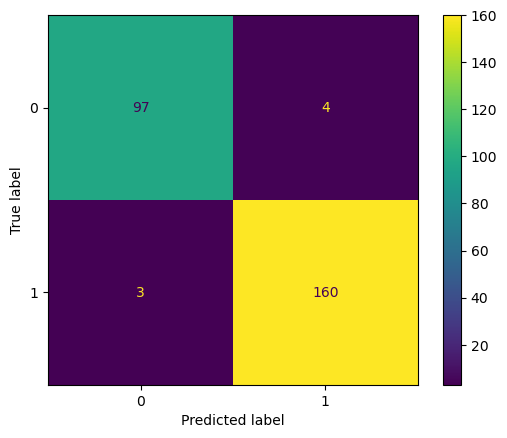

In [42]:
# Check predictiom outcomes

ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test)

#### Non heart attack (True label = 0):

- Number of correct prediction: 97
- Number of wrong prediction: 4 
    
#### Heart attack (True label = 1)

- Number of correct prediction: 160
- Number of wrong prediction: 3 

### Q7.4.2. Random Forest - assess overfitting

In [43]:
# model accuracy with train data

train_accuracy = accuracy_score(y_smote, best_rf_model.predict(X_smote))
train_f1 = f1_score(y_smote, best_rf_model.predict(X_smote))

# model accuracy with test data

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Training Accuracy: 0.9923
Training F1-Score: 0.9922
Test Accuracy: 0.9735
Test F1-Score: 0.9786


To assess potential overfitting, the random forest model's accuracy and F1-score were evaluated on both the training and test datasets. Since the differences in both metrics are minimal, the model does not exhibit signs of overfitting.

### Q7.5. Compare the models

All three models demonstrated strong predictive performance, with the decision tree model and random forest model performing similarly and outperforming the logistic regression model. As the prediction is relevant to saving human life, the high prediction accuracies are significant.

### Q8. Can patients be grouped based on medical features to identify the highest-risk group?

### Q8.1. Kmeans clustering with PCA visualization

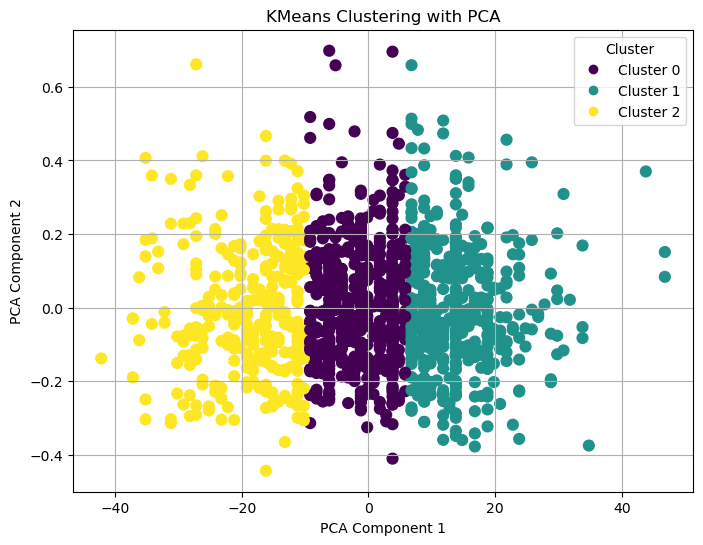

In [44]:
# Features

columns = ["age", "impulse", "pressurehigh", "pressurelow", "glucose", "kcm", "troponin"]
data = df[columns].values

# KMeans clustering 

kmeans = KMeans(n_clusters = 3, n_init = 10, random_state = 0)
df["cluster"] = kmeans.fit_predict(data)

# PCA

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(data)
df["pca1"] = pca_result[:, 0]
df["pca2"] = pca_result[:, 1]

# Visualization

plt.figure(figsize = (8, 6))
scatter = plt.scatter(df["pca1"], df["pca2"], c = df["cluster"], cmap = "viridis", s = 60)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clustering with PCA")

# Graph details

handles, _ = scatter.legend_elements()
labels = [f"Cluster {i}" for i in range(len(set(df["cluster"])))]
plt.legend(handles, labels, title = "Cluster")

plt.grid(True)
plt.show()

### Q8.2. Clustering outcome

In [45]:
cluster_counts = df["cluster"].value_counts().sort_index()
print(cluster_counts)

cluster
0    541
1    469
2    309
Name: count, dtype: int64


In [46]:
from sklearn.metrics import silhouette_score

score = silhouette_score(data, df["cluster"])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.518


The total patient population was grouped into three distinct clusters using KMeans clustering:

- Cluster 0: 41% of the total patients  
- Cluster 1: 35.6% of the total patients  
- Cluster 2: 23.4% of the total patients

The silhouette score was approximately 0.52, suggesting that the clustering structure is moderately well-defined. This indicates that the clusters are reasonably distinct, with some overlap. 

### Q8.3. Cluster analysis

In [47]:
cluster_means = df.groupby("cluster")[columns].mean()
print(cluster_means)

               age   impulse  pressurehigh  pressurelow   glucose       kcm  \
cluster                                                                       
0        54.890943  0.051099      0.471809     0.300147  0.228934  0.042850   
1        70.029851  0.053580      0.471698     0.293306  0.214412  0.058427   
2        37.466019  0.057457      0.466627     0.290369  0.215492  0.049291   

         troponin  
cluster            
0        0.041211  
1        0.042101  
2        0.013132  


In [48]:
heart_attack_col = "heart attack" 

ratio = df.groupby("cluster")[heart_attack_col].value_counts(normalize=True).unstack()
print(ratio)

heart attack         0         1
cluster                         
0             0.358595  0.641405
1             0.279318  0.720682
2             0.595469  0.404531


#### Cluster 0  
This group represents middle-aged, high-risk patients. Troponin and glucose levels are relatively elevated. The second highest heart attack rate suggests a need for proactive monitoring and lifestyle interventions

#### Cluster 1
This group is a high-risk elderly group. They exhibit the highest levels of kcm and troponin, indicating significant heart attack risk requiring immediate and continuous medical attention.

#### Cluster 2
This group consists of younger low-risk patients. Most medical features are relatively low. This group is significant from a preventive healthcare perspective. 

#### Implications
Patients in clusters 0 and 1 need focused care and monitoring to prevent or manage heart attack. The medical feature levels observed in cluster 2 can serve as a reference for identifying and managing high-risk patients.

## 7. Conclusion

This study was conducted to identify key medical predictors of heart attack, a growing cause of mortality in South Korea. The key results of the study are summarized as follows:

- kcm and troponin were identified as key medical predictors of heart attack.
- Other medical features showed no statistically significant associations with these key predictors.
- There is no statistically significant association between kcm and troponin.
- Age appears to have a potential association with heart attack and shows statistically significant associations with both kcm and troponin.
- While heart attack rate is relatively low in younger age groups, it drastically increases from the 50s onward.
- For kcm, the highest average level is observed in the 10s age group. Between the 20s and 70s, average levels remain relatively low and stable, followed by a noticeable increase in the 80s and beyond.
- In the case of troponin, average levels gradually increase from the 10s, peaking between the 60s and 90s. Levels remain consistently high from the 50s through 90s, with the highest level in the 90s. The lowest level is observed in the 10s.
- Gender has a statistically significant association with both heart attack and troponin.
- Male patients exhibit a higher heart attack rate than female patients.
- For troponin, males exhibit higher average levels than females.
- A decision tree or random forest model can be developed using the key predictors to classify or predict heart attack risk with high accuracy (97%-98%).
- PCA-based clustering using age and the six medical features can help identify high-risk groups for targeted intervention.

## 8. Research limitations

Although this research has found meaningful insights with high-performing prediction models, there were research limitations that can be addressed for subsequent research. 

- Due to the limited domain knowledge in the medical industry, outliers were retained without appropriate handling. The outliers should be key predictors for heart attack, but there must be outliers that are not acceptable in reality. Appropriate handling of outliers may improve the accuracy of research.
- For subsequent research, data on different medical factors should be collected and analyzed to predict heart attack. There must be more medical predictors such as diabetes influencing heart attack. 